# **Capstone Project**
## **Project Title: Pneumonia Detection in X-Rays Using Deep Learning**

**Author's Profile**:
- Name: Tan Yue Hang
- Academic Qualification:
    - Master of Engineering Science (M.Eng.Sc.)
    - Bachelor of Mechanical Engineering
- Certification & Achievements:
    - Six Sigma Green Belt
    - Academic publications
- Profession: Senior Process R&D Engineer
- Email: tan_hang2003@yahoo.com
- LinkedIn: [Yue Hang Tan](https://www.linkedin.com/in/yuehangtan/)

### Abstract:

The objective of this project is to develop a deep learning model that employs transfer learning with a pre-trained CNN model to distinguish between healthy lungs and those infected with pneumonia. The findings indicate that a recall score of 98% can be attained by using DenseNet169 for feature extraction from the chest X-Ray images, coupled with multiple dense layers with a sigmoid activation function for classification.

Data source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
# import system libraries
import os
import time
import shutil
import random
import warnings
warnings.filterwarnings("ignore")

# import standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import cv2


# Import data processing & evaluation libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from cv2 import imread, resize
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model, Model


# import tensorflow and keras
import tensorflow as tf
from keras.applications import VGG16, VGG19, MobileNetV3Large
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet152V2
from tensorflow.keras.applications import DenseNet169, DenseNet201, NASNetLarge
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical  # For one-hot encoding


# Setting random seed
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## 1. Image Data Preview and EDA
- Establish the path to the image folders.
- Move some of the images from test folders to validation folders.
- Preview some of the chest X-Ray images by random.

In [2]:
# Define the directory to the images data
# Each directory contains "Normal" and "Pneumonia" data folders
train_dir = r" "
val_dir = r" "
test_dir = r" "

### 1.1 Explore the dataset sample size

In [3]:
# Check the sample size of training data
sample_size = pd.DataFrame({
    "Train NORMAL": [len(os.listdir(os.path.join(train_dir, "NORMAL")))],
    "Train PNEUMONIA": [len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))],
    "Val NORMAL": [len(os.listdir(os.path.join(val_dir, "NORMAL")))],
    "Val PNEUMONIA": [len(os.listdir(os.path.join(val_dir, "PNEUMONIA")))],
    "Test NORMAL": [len(os.listdir(os.path.join(test_dir, "NORMAL")))],
    "Test PNEUMONIA": [len(os.listdir(os.path.join(test_dir, "PNEUMONIA")))]
    })

sample_size

,Train NORMAL,Train PNEUMONIA,Val NORMAL,Val PNEUMONIA,Test NORMAL,Test PNEUMONIA
0,1341,3875,108,208,134,190


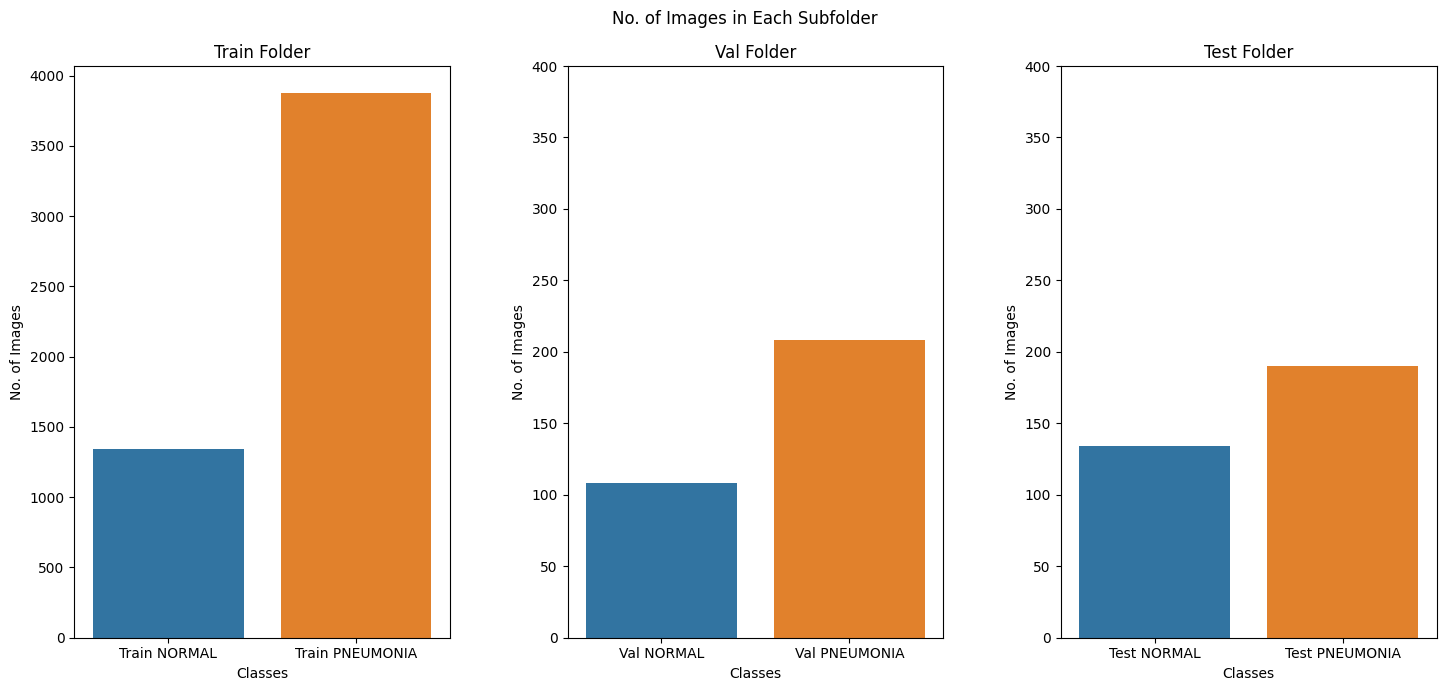

In [4]:
# Create barplot for the classes
fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(1, 3, 1)
sns.barplot(sample_size[["Train NORMAL", "Train PNEUMONIA"]], ax=ax1)
ax1.set_xlabel("Classes")
ax1.set_ylabel("No. of Images")
ax1.set_title("Train Folder")

ax2 = fig.add_subplot(1, 3, 2)
sns.barplot(sample_size[["Val NORMAL", "Val PNEUMONIA"]], ax=ax2)
ax2.set_ylim((0, 400))
ax2.set_xlabel("Classes")
ax2.set_ylabel("No. of Images")
ax2.set_title("Val Folder")

ax3 = fig.add_subplot(1, 3, 3)
sns.barplot(sample_size[["Test NORMAL", "Test PNEUMONIA"]], ax=ax3)
ax3.set_ylim((0, 400))
ax3.set_xlabel("Classes")
ax3.set_ylabel("No. of Images")
ax3.set_title("Test Folder")

# Adjust the spacing in-between the subplots
fig.subplots_adjust(wspace=8.5)

plt.suptitle("No. of Images in Each Subfolder")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

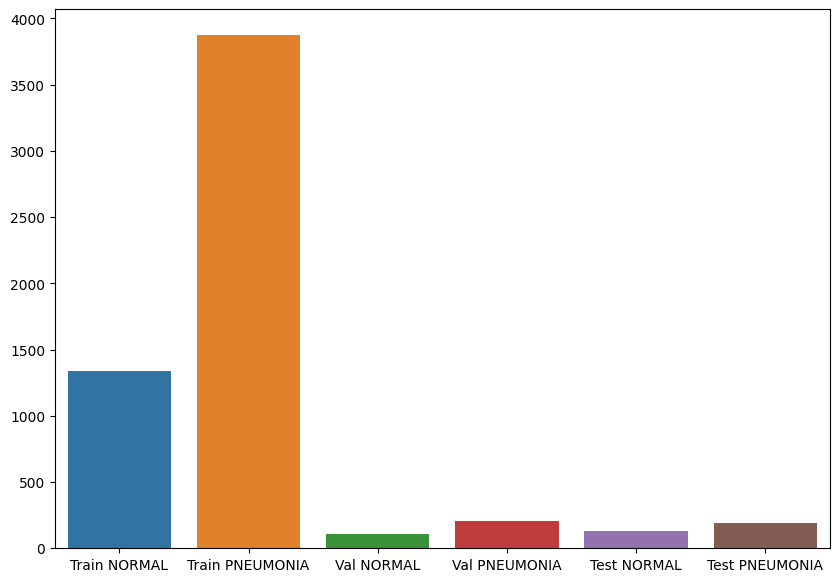

In [5]:
plt.figure(figsize=(10, 7))
sns.barplot(sample_size[["Train NORMAL", "Train PNEUMONIA", "Val NORMAL", "Val PNEUMONIA", "Test NORMAL", "Test PNEUMONIA"]])
plt.show();

Apparently there are way too less of validation data available. Too little validation images will lead to problematic validation metrics down the line.

Hence in order to balance out a bit, we will move the following images from `Test` to `Val` folders.
- 100 `Normal` images
- 200 `PNEUMONIA` images 

#### **NOTE:** Uncomment the following cell, and it should only be executed **ONCE** or else more images than intended will be moved from test to val folders!

In [6]:
# # Define how many NORMAL and PNEUMONIA images data to be moved from text to val folders
# MOVE_NORMAL_TEST_TO_VAL = 100
# MOVE_PNEUMONIA_TEST_TO_VAL = 200

# # To randomly move 100 NORMAL images from Test to Val folder
# source_test_normal = os.path.join(test_dir, "NORMAL")
# destination_val_normal = os.path.join(val_dir, "NORMAL")

# random_normal = random.sample(os.listdir(source_test_normal), MOVE_NORMAL_TEST_TO_VAL)

# for item in random_normal:
#     shutil.move(os.path.join(source_test_normal, item), os.path.join(destination_val_normal, item))


# # To randomly move 200 PNEUMONIA images from Test to Val folder
# source_test_pneumonia = os.path.join(test_dir, "PNEUMONIA")
# destination_val_pneumonia = os.path.join(val_dir, "PNEUMONIA")

# random_pneumonia = random.sample(os.listdir(source_test_pneumonia), MOVE_PNEUMONIA_TEST_TO_VAL)

# for item in random_pneumonia:
#     shutil.move(os.path.join(source_test_pneumonia, item), os.path.join(destination_val_pneumonia, item))

In [7]:
# Check the sample size of training data again after moving some images around
sample_size = pd.DataFrame({
    "Train NORMAL": [len(os.listdir(os.path.join(train_dir, "NORMAL")))],
    "Train PNEUMONIA": [len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))],
    "Val NORMAL": [len(os.listdir(os.path.join(val_dir, "NORMAL")))],
    "Val PNEUMONIA": [len(os.listdir(os.path.join(val_dir, "PNEUMONIA")))],
    "Test NORMAL": [len(os.listdir(os.path.join(test_dir, "NORMAL")))],
    "Test PNEUMONIA": [len(os.listdir(os.path.join(test_dir, "PNEUMONIA")))]
    })

sample_size

,Train NORMAL,Train PNEUMONIA,Val NORMAL,Val PNEUMONIA,Test NORMAL,Test PNEUMONIA
0,1341,3875,108,208,134,190


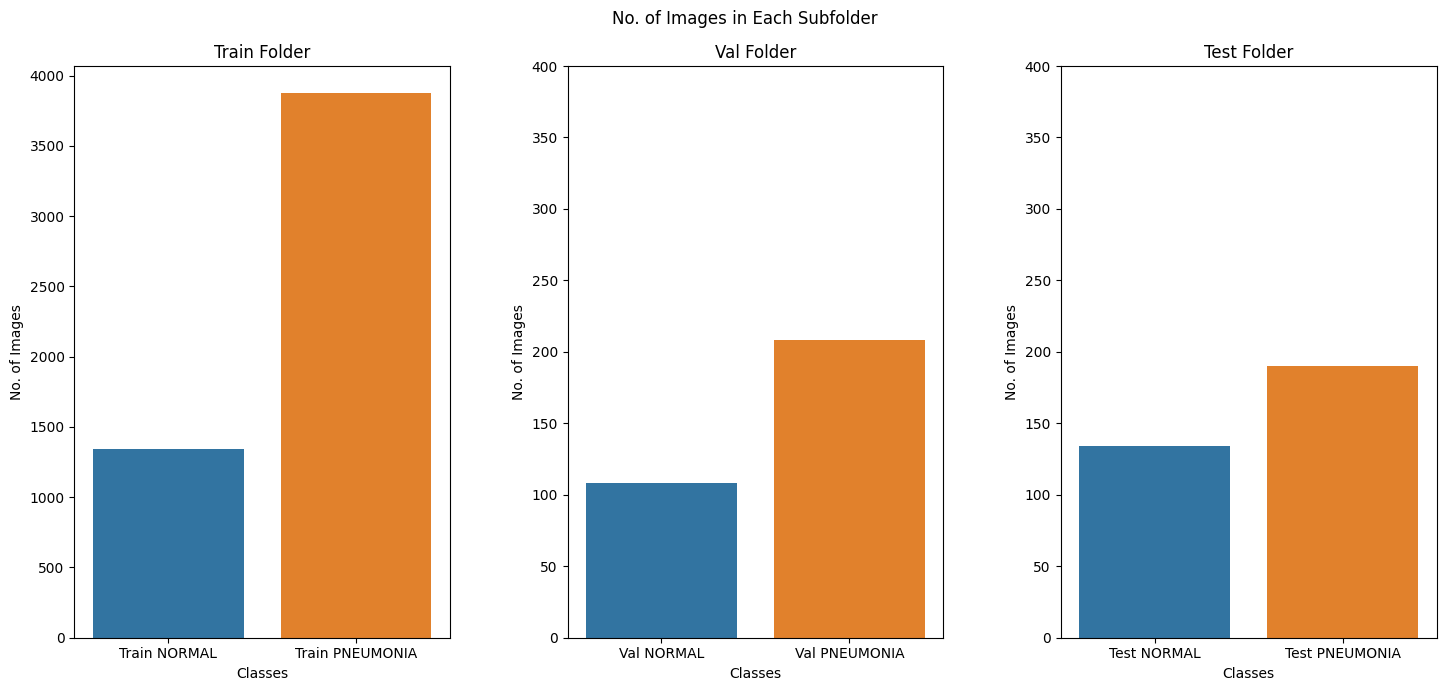

In [8]:
# Create barplot for the classes
fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(1, 3, 1)
sns.barplot(sample_size[["Train NORMAL", "Train PNEUMONIA"]], ax=ax1)
ax1.set_xlabel("Classes")
ax1.set_ylabel("No. of Images")
ax1.set_title("Train Folder")

ax2 = fig.add_subplot(1, 3, 2)
sns.barplot(sample_size[["Val NORMAL", "Val PNEUMONIA"]], ax=ax2)
ax2.set_ylim((0, 400))
ax2.set_xlabel("Classes")
ax2.set_ylabel("No. of Images")
ax2.set_title("Val Folder")

ax3 = fig.add_subplot(1, 3, 3)
sns.barplot(sample_size[["Test NORMAL", "Test PNEUMONIA"]], ax=ax3)
ax3.set_ylim((0, 400))
ax3.set_xlabel("Classes")
ax3.set_ylabel("No. of Images")
ax3.set_title("Test Folder")

# Adjust the spacing in-between the subplots
fig.subplots_adjust(wspace=8.5)

plt.suptitle("No. of Images in Each Subfolder")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

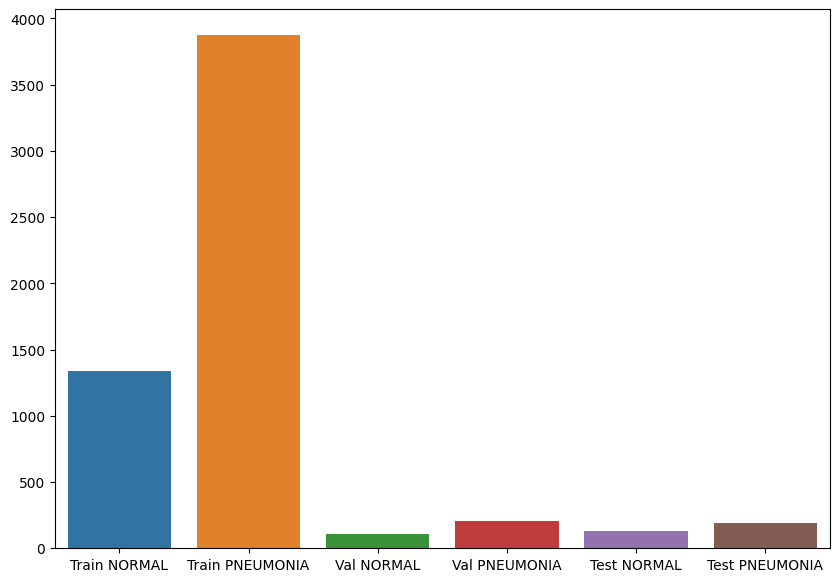

In [9]:
plt.figure(figsize=(10, 7))
sns.barplot(sample_size[["Train NORMAL", "Train PNEUMONIA", "Val NORMAL", "Val PNEUMONIA", "Test NORMAL", "Test PNEUMONIA"]])
plt.show();

Now there are more validation images than before, which should be more robust for model evaluation later.

### 1.2 Preview the chest X-Ray images

In [10]:
# List all the images in the training directory
train_normal = [item for item in os.listdir(os.path.join(train_dir, "NORMAL"))]
train_pneumonia = [item for item in os.listdir(os.path.join(train_dir, "PNEUMONIA"))]

val_normal = [item for item in os.listdir(os.path.join(val_dir, "NORMAL"))]
val_pneumonia = [item for item in os.listdir(os.path.join(val_dir, "PNEUMONIA"))]

test_normal = [item for item in os.listdir(os.path.join(test_dir, "NORMAL"))]
test_pneumonia = [item for item in os.listdir(os.path.join(test_dir, "PNEUMONIA"))]

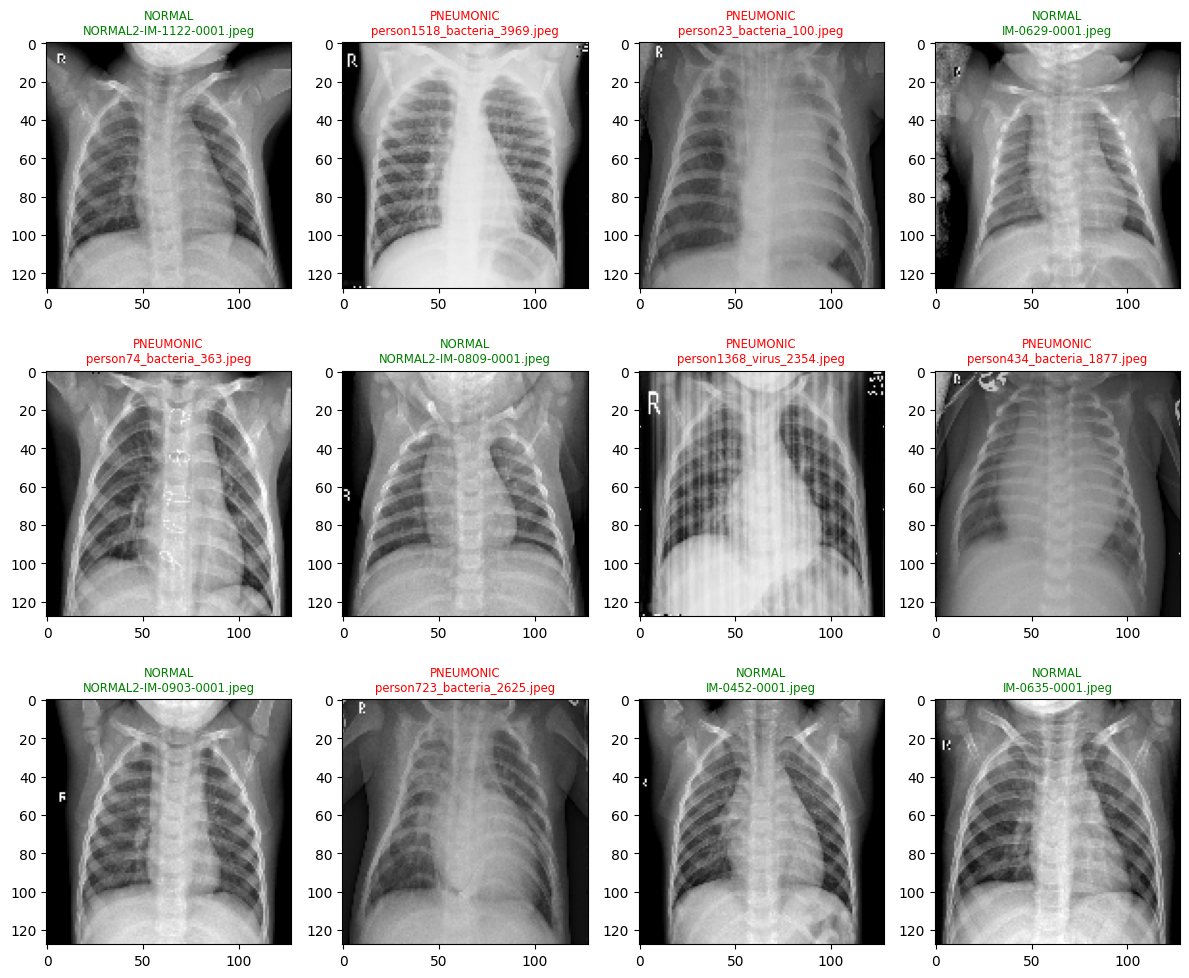

In [11]:
# Set the number of images to preview
IMAGES_PREVIEW_ROW = 3
IMAGES_PREVIEW_COLS = 4


# Load and preview the images by random
fig = plt.figure(figsize=(12, 10))

total_images = IMAGES_PREVIEW_ROW*IMAGES_PREVIEW_COLS
ax = [None]*total_images

for item in range(0, total_images):
    random_num_normal = np.random.randint(0, len(os.listdir(os.path.join(train_dir, "NORMAL"))))
    random_num_pneumonia = np.random.randint(0, len(os.listdir(os.path.join(train_dir, "PNEUMONIA"))))
    dice_roll = np.random.randint(0, 2)
    if dice_roll == 0:
        ax[item] = fig.add_subplot(IMAGES_PREVIEW_ROW, IMAGES_PREVIEW_COLS, item+1)
        img = load_img(os.path.join(train_dir, "NORMAL", train_normal[random_num_normal]), target_size=(128, 128))
        ax[item].imshow(img)
        ax[item].set_title(f"NORMAL\n{train_normal[random_num_normal]}", color="green", fontsize=100/total_images)
    
    elif dice_roll == 1:
        ax[item] = fig.add_subplot(IMAGES_PREVIEW_ROW, IMAGES_PREVIEW_COLS, item+1)
        img = load_img(os.path.join(train_dir, "PNEUMONIA", train_pneumonia[random_num_pneumonia]), target_size=(128, 128))
        ax[item].imshow(img)
        ax[item].set_title(f"PNEUMONIC\n{train_pneumonia[random_num_pneumonia]}", color="red", fontsize=100/total_images)

plt.tight_layout()
plt.show();

## 2. Instantiate Keras Data generator to Import Images
- Instantiate Keras ImageDataGenerator. Set augmentation if necessary.
- Instantiate the image data loading iterable object. Define the input image size, batch size and class mode.
- Check the classs indices. This is useful for classification threshold setting later on.

In [12]:
# Instantiate the data generator
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255.
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

=============================================================================================================================================================================================================================================================================================

#### Tune the hyperparameters here

In [13]:
# Define the key input hyperparameters
CNN_MODEL = DenseNet169
BATCH_SIZE = 6          # Fixed as 6
EPOCHS = 5              # Fixed as 5, as the model manage to achieve the best weights in under 5 epochs most of the time
img_input_size = 448
img_size = (img_input_size, img_input_size)
img_shape = (img_input_size, img_input_size, 3)

=============================================================================================================================================================================================================================================================================================

In [38]:
# Load training, validation, and test image data
train_img = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    class_mode="binary"
)

val_img = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=img_size,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    class_mode="binary"
)

test_img = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 316 images belonging to 2 classes.
Found 324 images belonging to 2 classes.


Preview the **augmented** chest X-Ray images

Found 5216 images belonging to 2 classes.


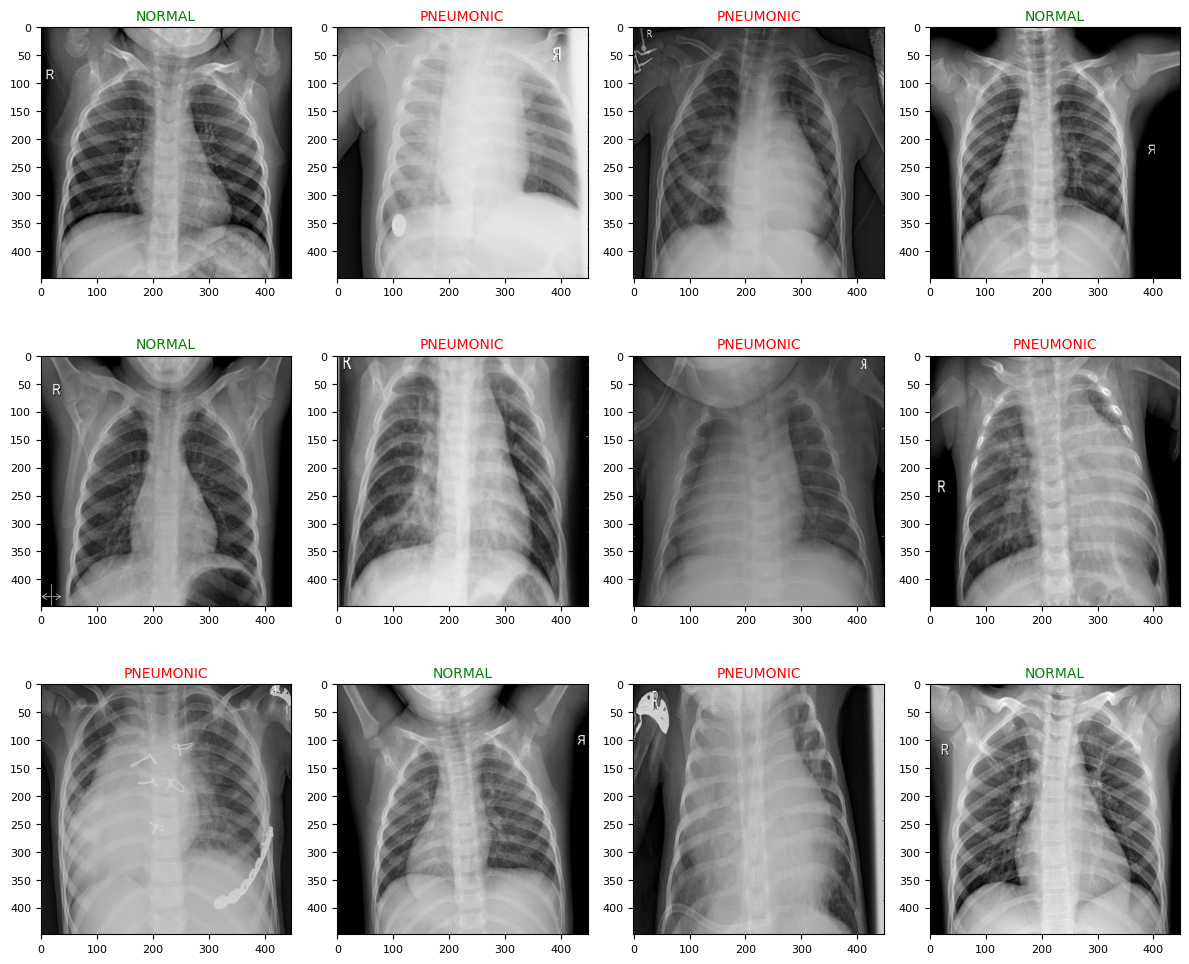

In [15]:
# Define the train images importer for plotting only
train_img_plot = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    color_mode="rgb",
    batch_size=12,
    shuffle=True,
    seed=42,
    class_mode="binary"
)

# Set the number of images to preview
IMAGES_PREVIEW_ROW = 3
IMAGES_PREVIEW_COLS = 4

# Load and preview the images by random
fig = plt.figure(figsize=(12, 10))

total_images = IMAGES_PREVIEW_ROW*IMAGES_PREVIEW_COLS
ax = [None]*total_images

for i in range(total_images):
    # Get a batch of images from the train_img generator
    images, label = next(train_img_plot)

    # Generate random index
    index = np.random.randint(0, images.shape[0])
  
    ax[i] = fig.add_subplot(IMAGES_PREVIEW_ROW, IMAGES_PREVIEW_COLS, i+1)
    ax[i].imshow(images[index])
    if label[index] == 1.0:
        ax[i].set_title(f"PNEUMONIC", fontsize=10, pad=5, color="red")
    elif label[index] == 0.0:
        ax[i].set_title(f"NORMAL", fontsize=10, pad=5, color="green")
    ax[i].tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show();

In [16]:
# Check the class indices
train_class_indices = train_img.class_indices
val_class_indices = val_img.class_indices
test_class_indices = test_img.class_indices


train_class_indices, val_class_indices, test_class_indices

({'NORMAL': 0, 'PNEUMONIA': 1},
 {'NORMAL': 0, 'PNEUMONIA': 1},
 {'NORMAL': 0, 'PNEUMONIA': 1})

## 3. Build Model with Pre-trained CNN Models from Keras
- Define a helper function to build DL model and train it.

In [17]:
def train_model(train_data, val_data, cnn_model, img_shape, BATCH_SIZE, EPOCHS, CALLBACK=True):
    """
    1. Pass training images
    2. Pass validation images
    3. Pass a pre-trained CNN model to be used without the ()
    4. Pass the image shape, E.g. (224, 224, 3)
    5. Pass batch_size
    6. Pass number of epochs
    7. Whether to implement ModelCheckpoint and EarlyStopping (True or False)
    """
    # Instantiate a pre-trained CNN model
    base_model = cnn_model(
        weights="imagenet",
        include_top=False,
        input_shape=img_shape
    )

    # Freeze all the pre-trained CNN layers
    for layer in base_model.layers:
        layer.trainable=False

    # Flatten the output layer of the base model
    flat = GlobalAveragePooling2D()(base_model.output)


    ## Add the FIRST dense layer
    # Add batch normalization
    batch_nom_1 = BatchNormalization()(flat)
    # Add dense layer
    dense_1 = Dense(32, activation="relu")(batch_nom_1)
    # Add dropout layer
    dropout_1 = Dropout(rate=0.25, seed=42)(dense_1)
    

    ## Add the SECOND dense layer
    # Add batch normalization
    batch_nom_2 = BatchNormalization()(dropout_1)
    # Add dense layer
    dense_2 = Dense(224, activation="relu")(batch_nom_2)
    # Add dropout layer
    dropout_2 = Dropout(rate=0.25, seed=42)(dense_2)
    

    # Add dense layer as output for classification
    dense_4 = Dense(1, activation="sigmoid")(dropout_2)
 
    model = Model(inputs=base_model.input, outputs=dense_4)

    # Compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer="Adam",
        metrics=["accuracy", Precision(), Recall()]
    )

    # Show model summary
    model.summary()

    # Apply model checkpoint to store the best model
    checkpoint = ModelCheckpoint(
        "best_model",
        monitor="val_recall",
        save_best_only=True,
        mode="max"
    )

    # Apply early stopping to potentially save training time
    early_stop = EarlyStopping(
        monitor="val_recall",
        patience=3
    )

    if CALLBACK == False:
        # Train the model
        history = model.fit(
            train_data,
            validation_data=val_data,
            shuffle=True,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            class_weight={
                0:3,    # "NORMAL" images sample size is only 30% of the "PNEUMONIA" images sample size
                1:1
            }
        )
    
    else:
        # Train the model
        history = model.fit(
            train_data,
            validation_data=val_data,
            shuffle=True,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            callbacks=[checkpoint, early_stop],    # The sequence does matter. if EarlyStopping is triggered, the model weights from the current epoch will not be saved by ModelCheckpoint.
            class_weight={
                0:3,    # "NORMAL" images sample size is only 30% of the "PNEUMONIA" images sample size
                1:1
            }
        )

    return history

In [18]:
%%time
history = train_model(
    train_img,
    val_img,
    CNN_MODEL,
    img_shape,
    BATCH_SIZE,
    EPOCHS,
    CALLBACK=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 454, 454, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 224, 224, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


870/870 [==============================] - 224s 246ms/step - loss: 0.4040 - accuracy: 0.8907 - precision: 0.9699 - recall: 0.8803 - val_loss: 0.2186 - val_accuracy: 0.9209 - val_precision: 0.9178 - val_recall: 0.9663
Epoch 2/5
870/870 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.9130 - precision: 0.9732 - recall: 0.9079

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


870/870 [==============================] - 200s 229ms/step - loss: 0.3233 - accuracy: 0.9130 - precision: 0.9732 - recall: 0.9079 - val_loss: 0.2149 - val_accuracy: 0.9335 - val_precision: 0.9269 - val_recall: 0.9760
Epoch 3/5
870/870 [==============================] - 168s 192ms/step - loss: 0.2655 - accuracy: 0.9279 - precision: 0.9768 - recall: 0.9249 - val_loss: 0.1980 - val_accuracy: 0.9241 - val_precision: 0.9220 - val_recall: 0.9663
Epoch 4/5
870/870 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.9325 - precision: 0.9814 - recall: 0.9267

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


870/870 [==============================] - 203s 233ms/step - loss: 0.2524 - accuracy: 0.9325 - precision: 0.9814 - recall: 0.9267 - val_loss: 0.2536 - val_accuracy: 0.9209 - val_precision: 0.9031 - val_recall: 0.9856
CPU times: total: 17min 3s
Wall time: 13min 19s


## 4. Model Evaluation

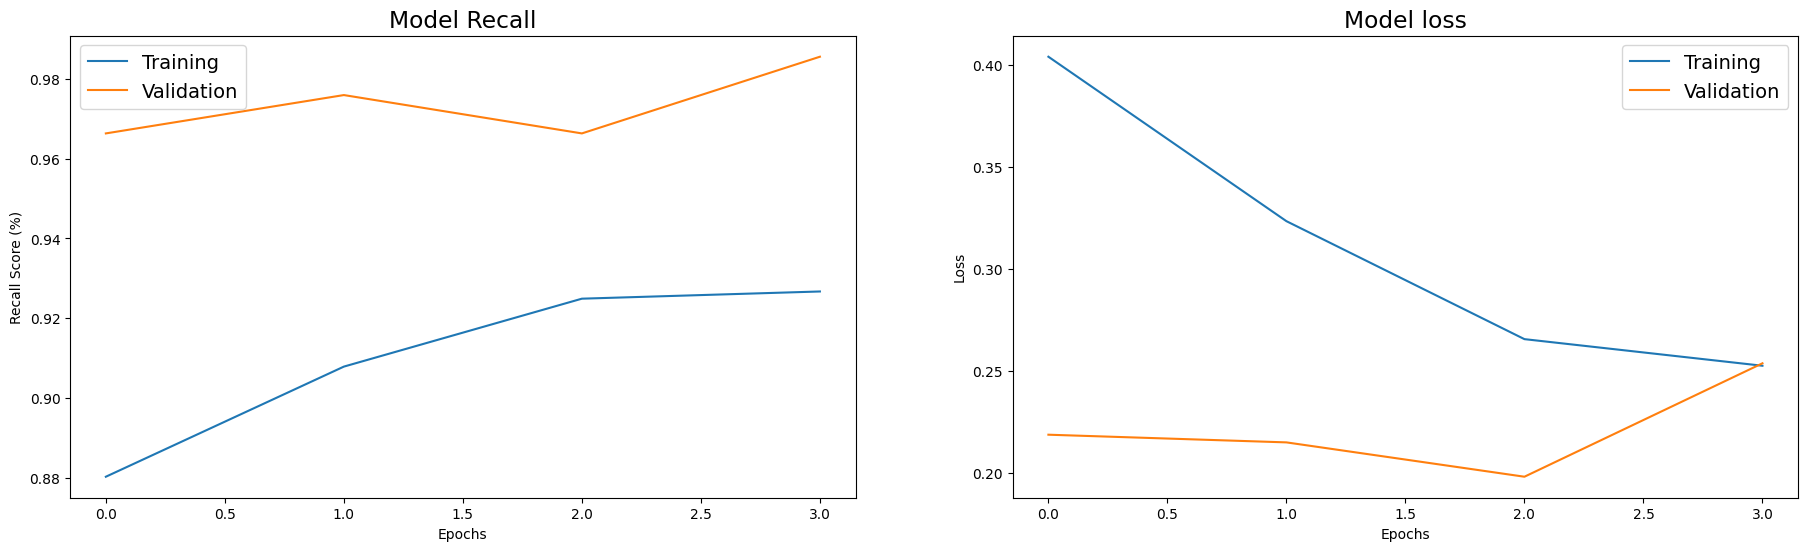

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 14})

# Plot training & validation Recall values
ax[0].plot(history.history['recall'], label = 'Training')
ax[0].plot(history.history['val_recall'], label = 'Validation')
ax[0].set_title('Model Recall')
ax[0].set_ylabel('Recall Score (%)')
ax[0].set_xlabel('Epochs')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.show()

In [39]:
# Preview the true labels
test_img.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [40]:
# Assign the true labels
true_labels = test_img.classes

In [41]:
# Load the best model from the training epochs
model = load_model("best_model")

In [42]:
# Make classifications with the best model
pred = model.predict(test_img, steps=len(test_img), verbose=1)

54/54 [==============================] - 12s 181ms/step


In [43]:
# Preview the classifications in probabilities
pred[:5]

array([[0.01760625],
       [0.0283102 ],
       [0.0056776 ],
       [0.00186167],
       [0.01961315]], dtype=float32)

In [44]:
# Preview the class indices of the binary classes
test_class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [45]:
# Set the classification threshold. Change the value to fine-tune it.
threshold = 0.5

# Predict the output as binary classes
predicted_labels = [0 if item[0] < threshold else 1 for item in pred]

In [46]:
len(predicted_labels)

324

In [47]:
# Construct confusion matrix
cf = confusion_matrix(true_labels, predicted_labels)

In [48]:
# Classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.75      0.86       134
           1       0.85      0.99      0.92       190

    accuracy                           0.90       324
   macro avg       0.92      0.87      0.89       324
weighted avg       0.91      0.90      0.89       324



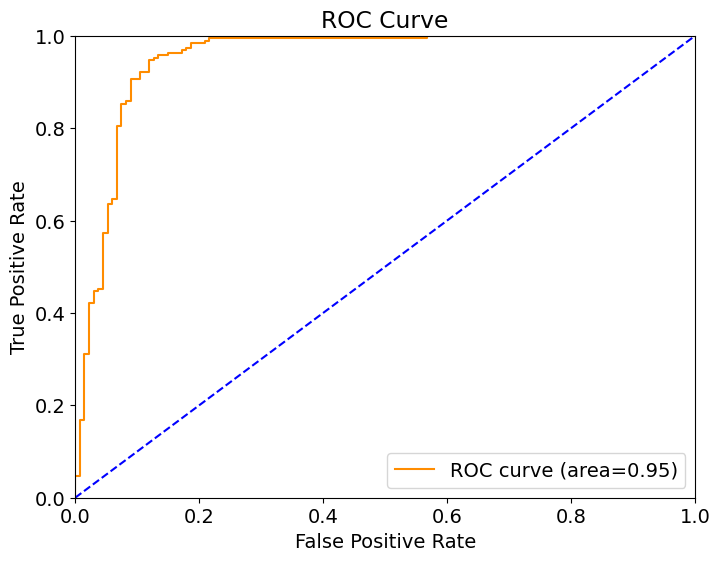

In [49]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(true_labels, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", label = f"ROC curve (area={round(roc_auc, 2)})")
plt.plot([0, 1], [0, 1], color = "blue", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1.])
plt.legend(loc="lower right")
plt.show();

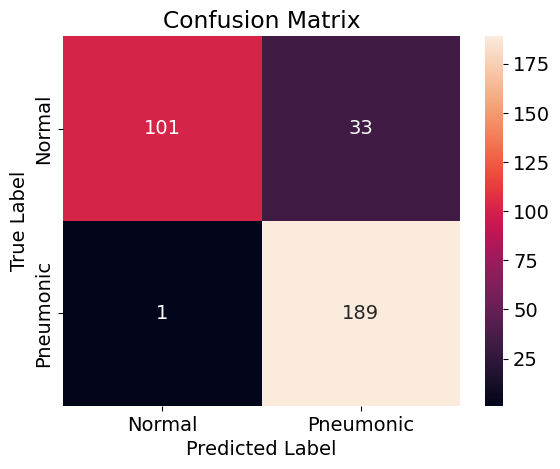

In [50]:
# Generate confusion matrix in heatmap
sns.heatmap(cf, annot=True, fmt="d", xticklabels=["Normal", "Pneumonic"], yticklabels=["Normal", "Pneumonic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show();

In [51]:
# Compute accuracy score
accuracy_test = accuracy_score(true_labels, predicted_labels)
accuracy_test

0.8950617283950617

In [52]:
# Compute precision score
precision_test = precision_score(true_labels, predicted_labels)
precision_test

0.8513513513513513

In [53]:
# Compute recall score
recall_test = recall_score(true_labels, predicted_labels)
recall_test

0.9947368421052631

In [54]:
# Compute f1 score
f1_test = f1_score(true_labels, predicted_labels)
f1_test

0.9174757281553398

In [55]:
# Compile the metrics (with test data) in DataFrame
results = pd.DataFrame({
    "Accuracy": [accuracy_test],
    "Precision": [precision_test],
    "Recall": [recall_test],
    "F1": [f1_test]
})

results

,Accuracy,Precision,Recall,F1
0,0.895062,0.851351,0.994737,0.917476


Uncomment the following cell if you want to save the model.

In [57]:
# # Save the model
# model.save(r"densenet_model.h5")

## Summary:
1. Since this is a medical diagnosis, we aim to minimize `False Negative` as it's better to misclassify patients who don't actually have pneumonia as positive rather than classifying any potential positive pneumonia as negative. Maximizing `Recall` can achieve this objective.
2. Please refer to the PowerPoint presentation slides for more in-depth discussions on the potential applications, fine-tuning, and model deployment in application (done in a separate Jupyter Notebook).